# Face Recognition

In [3]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
from scipy import io as sp
import dlib
import os
import itertools as it
import pixiedust
colors = sns.color_palette()

Pixiedust database opened successfully


### Load celebrity name data

In [4]:
celebName = pd.read_csv('Top1M_MidList.Name.tsv',names=['Id','Name'], delimiter='\t', error_bad_lines=False)
language = celebName['Name'].str.split("@", n=1, expand=True)
celebName['Name'] = language[0]
celebName['Language'] = language[1]
celebName = celebName[celebName['Language'] == 'en']
celebName.drop(columns=['Language'], inplace=True)

### Load celebrity images

In [5]:
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)

### Join on id

In [6]:
clebs = clebs.merge(celebName, how='left', left_on='Id', right_on='Id')
del celebName

In [7]:
clebs.head()

,Id,Image,Name
0,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
1,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
2,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
3,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
4,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon


### Data distribution

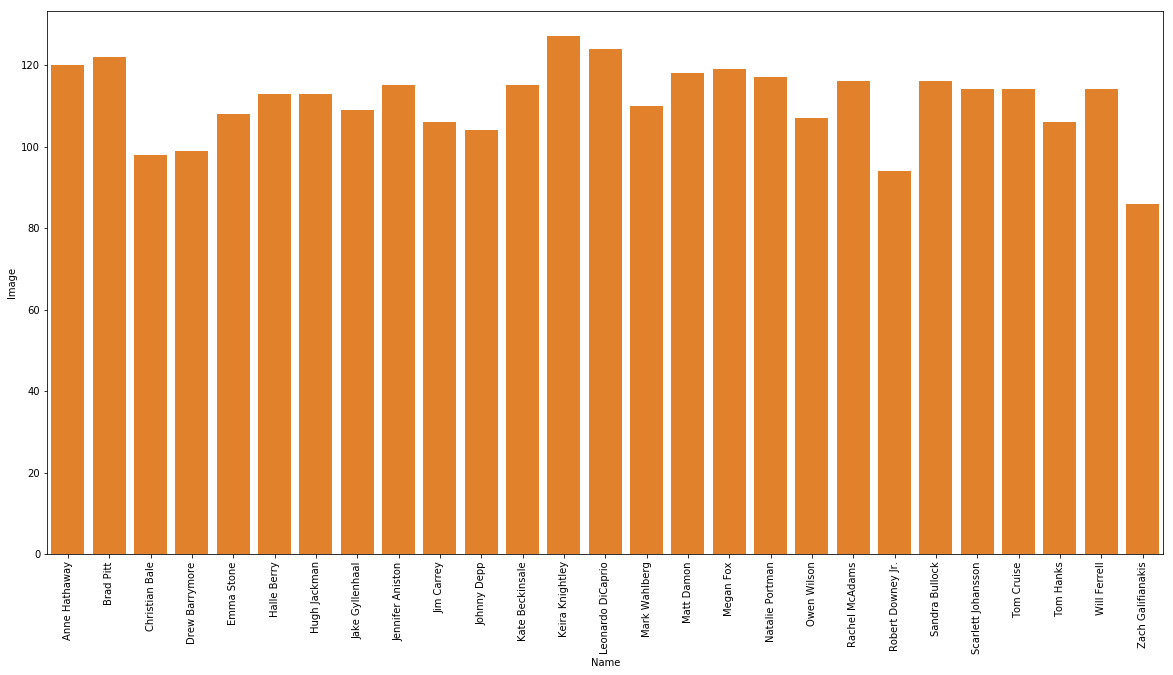

In [8]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

In [9]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

# TODO

In [10]:
def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

In [11]:
def detect_faces(test_image, display=True, scaleFactor = 1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(test_image, 1)
    
    if display:
        image_copy = test_image.copy()
        for rect in faces_rect:
            (x,y,w,h) = rect_to_cordinate(rect)
            cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

In [12]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [13]:
def detect_landmarks(image, faces, display=True):
    pose_landmarks = None
    face_pose_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    
    if display:
        test_copy = image.copy()
    
    for face in faces:
        pose_landmarks = face_pose_predictor(image, face)
        if display:
            for (x, y) in shape_to_np(pose_landmarks):
                cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    
    return pose_landmarks

In [14]:
def scale_face(image, landmarks, display=True):
    fod = dlib.full_object_detections()
    fod.append(landmarks)
    img = dlib.get_face_chips(image, fod, size=128)
    if display:
        for x in img:
            plt.figure(figsize=(8,8))
            plt.imshow(convertToRGB(x))
    return img

In [15]:
def get_scaled(base64image,display=False):
    img_raw = get_opencv2_image(base64image)
    faces = detect_faces(img_raw,display=False)
    if not faces:
        return np.nan
    landmarks = detect_landmarks(img_raw, faces,display=False)
    scaleimg = scale_face(img_raw, landmarks, display=display)
    return scaleimg[0]


### Detect Faces

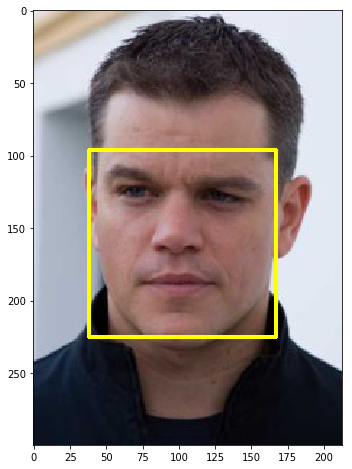

In [16]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

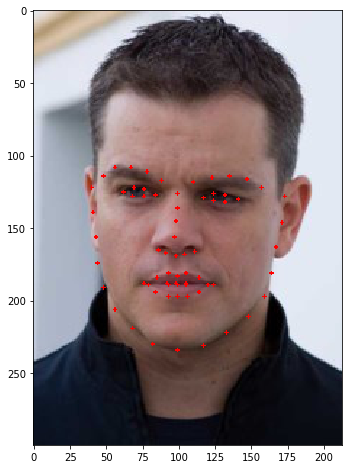

In [17]:
landmarks = detect_landmarks(img_raw, faces)

# Scale And Align Images

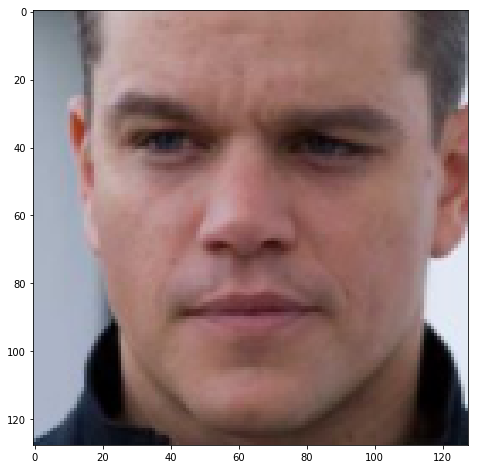

In [18]:
scaleimg = scale_face(img_raw, landmarks, display=True)

In [19]:
# n = len(clebs)
# for i in range(n):
#     print('Progess [{}/{}]'.format(i,n))
#     if rand.randint(0,10) > 9:
#         clebs.iloc[i]['Image'] = get_scaled(clebs.iloc[i]['Image'], display=False)
#     else:
#         clebs.iloc[i]['Image'] = np.nan
# clebs.dropna(inplace=True)
# np.save('scaled_subset', clebs.values)

In [20]:
dataset = np.load('scaled_subset.npy')
labels = np.unique(dataset.T[:][0])
x_positive = []
x_negative = []

positive_sample_size = 0.1
negative_sample_size = 0.0001

for l in labels:
    combos_positive = list(it.combinations(dataset[np.where(dataset.T[:][0] == l)].T[1], 2))
    index = np.arange(len(combos_positive))
    np.random.shuffle(index)
    index = index[: int(len(combos_positive)*positive_sample_size)]
    x_positive += [combos_positive[j] for j in index]
    
    combos_negative = list(it.combinations(dataset[np.where(dataset.T[:][0] != l)].T[1], 2))
    index = np.arange(len(combos_negative))
    np.random.shuffle(index)
    index = index[: int(len(combos_negative)*negative_sample_size)]
    x_negative += [combos_negative[j] for j in index]

print('Stacking Arrays')
X = np.vstack((np.asarray(x_positive), np.asarray(x_negative)))
y = np.vstack((np.full((len(x_positive),1),0), np.full((len(x_negative),1),1)))
print(X.shape)
print(y.shape)
np.save('Dataset', X)
np.save('Labels', y)

Stacking Arrays
(3514, 2, 128, 128, 3)
(3514, 1)


In [21]:
X = np.load('Dataset.npy')
y = np.load('Labels.npy')

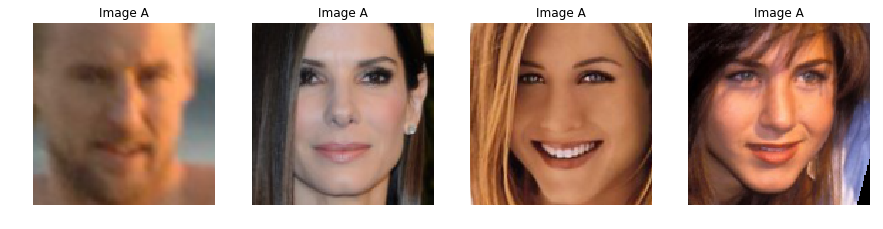

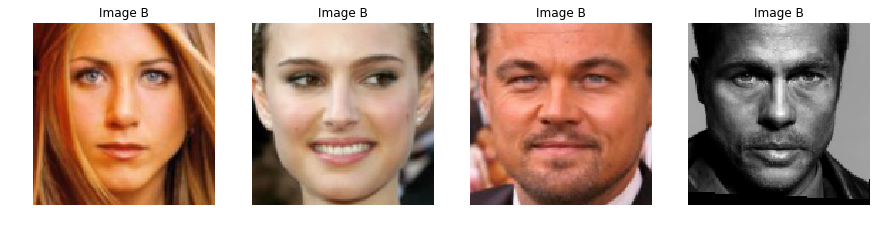

In [22]:
Xs = X[np.random.choice(np.where(y[:]==1)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][0]))
    axarr[i].axis('off')
    axarr[i].set_title('Image A')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][1]))
    axarr[i].axis('off')
    axarr[i].set_title('Image B')

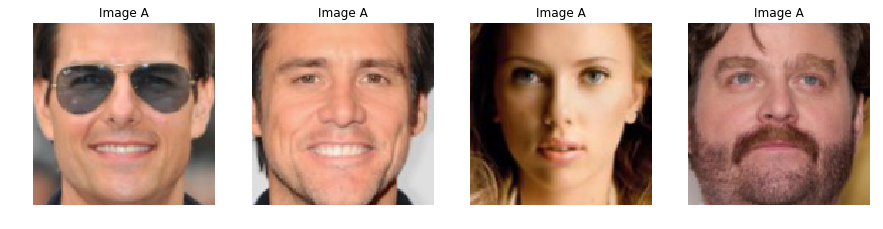

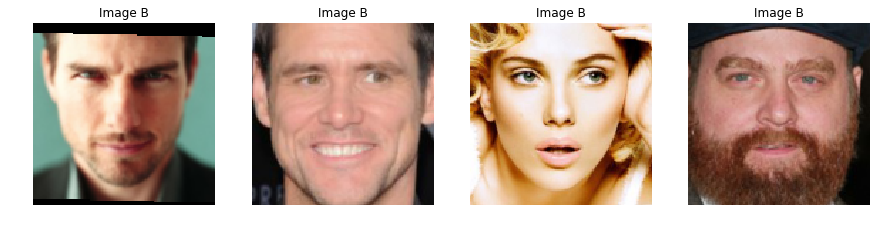

In [23]:
Xs = X[np.random.choice(np.where(y[:]==0)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][0]))
    axarr[i].axis('off')
    axarr[i].set_title('Image A')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][1]))
    axarr[i].axis('off')
    axarr[i].set_title('Image B')

In [24]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    seq.summary()
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

Using TensorFlow backend.


In [25]:
image_dimension = [128,128,3]
input_dim = image_dimension
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [26]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = image_dimension, name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = 3, activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = 3, activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      1168      
_________________________________________________________________
batch_normalization_2

In [27]:
from keras.layers import concatenate
img_a_in = Input(shape = image_dimension, name = 'ImageA_Input')
img_b_in = Input(shape = image_dimension, name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           869984      ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [28]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

In [29]:
Xs = X[:100]
Ys = y[:100]

In [39]:
x1 = Xs[:,0,:,:,:]
x2 = Xs[:,1,:,:,:]

In [31]:
pp = [x1]

(2, 128, 128, 3)